# Time series analysis with ARIMA
Some time ago I had a discussion about time series analysis and ARIMA models, which found me quite unprepared!
So I decided to look a bit closer to this neat piece of classical time series analysis. I found out that there are several excellent tutorials on how to use ARIMA, which I link below. Still, I found it useful to compile my own example to summarize my understanding of the problem and to collect links to useful resources.

## Import libraries and get sample data

In [157]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

Get the classic international airline passengers data, downloadable from the DataMarket webpage (https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV with filename "international-airline-passengers.csv".

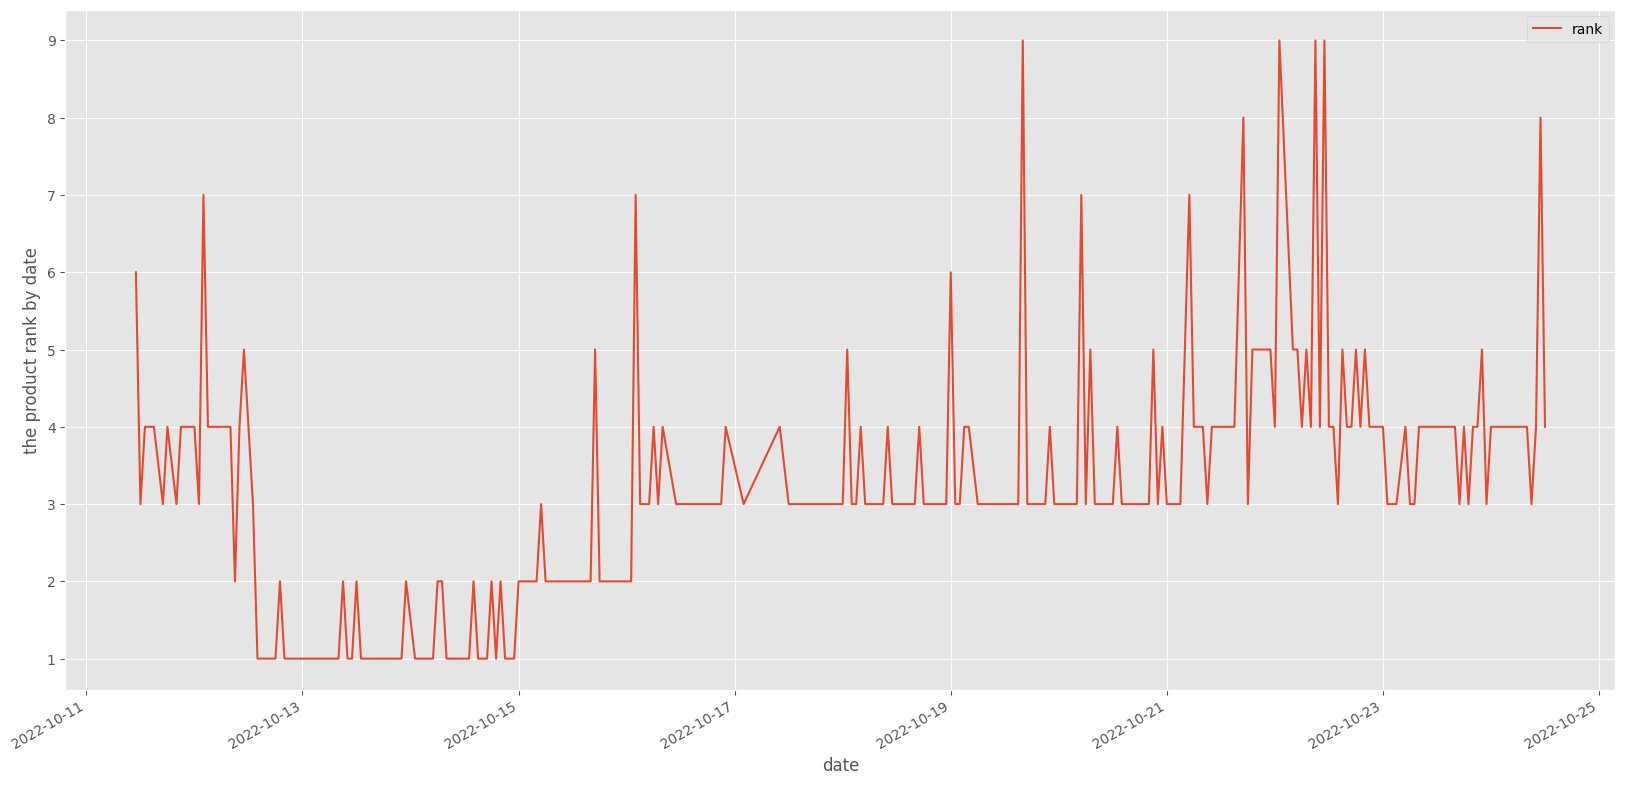

In [158]:
# Load the data
data = pd.read_csv('/home/huhao/scripts/time_series/data/B06X6J3L65_rank.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
data['date']=pd.to_datetime(data['date'])
data.set_index(['date'], inplace=True)

# Plot the data
data.plot()
plt.ylabel('the product rank by date')
plt.xlabel('date')
plt.show()

Two obvious patterns appear in the data, an overall increase in the number of passengers over time, and a 12 months seasonality with peaks corresponding to the northern emisphere summer period.

## ARIMA
ARIMA stands for Auto-Regressive Integrated Moving Average. There are three  integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q): 
<ul>
<li><strong>p</strong> is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.</li>
<li><strong>d</strong> is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.</li>
<li><strong>q</strong> is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.</li>
</ul>

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (<strong>P, D, Q</strong>) follow the same definition but are applied to the seasonal component of the time series. The term <strong>s</strong> is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters? 

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: 
http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3). 

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [159]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We select a subset of the data series as training data, say the first 11 years. Our goal is to predict the last year of the series based on this input.

In [160]:
train_data = data['2022-10-11-11':'2022-10-22-23']
test_data = data['2022-10-23-00':'2022-10-24-10']

In [161]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            #print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62908D+00    |proj g|=  2.62510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.508D-06   2.629D+00
  F =   2.6290625110702543     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.3

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.064E-03  -gs= 2.222E-03 BFGS update SKIPPED

At iterate    5    f=  1.60866D+00    |proj g|=  6.97430D-03

At iterate   10    f=  1.60862D+00    |proj g|=  4.72425D-02

At iterate   15    f=  1.60862D+00    |proj g|=  2.57594D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     27      1     1     0   2.576D-07   1.609D+00
  F =   1.6086165355373392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63187D+00    |proj g|=  2.22922D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     12      1     0     0   2.229D-05   1.632D+00
  F =   1.6318691061939337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.42897D+00    |proj g|=  5.50606D-03

At iterate   10    f=  1.42891D+00    |proj g|=  5.02780D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   5.028D-06   1.429D+00
  F =   1.4289127004651667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45904D+00    |proj g|=  2.45205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     12      1     0     0   2.451D-05   1.459D+00
  F =   1.4590394989974114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

 This problem is unconstrained.



At iterate   10    f=  1.37213D+00    |proj g|=  5.43532D-02

At iterate   15    f=  1.37120D+00    |proj g|=  1.42181D-01

At iterate   20    f=  1.37054D+00    |proj g|=  1.21743D-02

At iterate   25    f=  1.37045D+00    |proj g|=  6.03098D-02

At iterate   30    f=  1.37043D+00    |proj g|=  5.09197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     34      1     0     0   5.092D-04   1.370D+00
  F =   1.3704347225115101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37373D+00    |proj g|=  2.07476D-01


 This problem is unconstrained.



At iterate    5    f=  1.35881D+00    |proj g|=  2.46818D-02

At iterate   10    f=  1.35811D+00    |proj g|=  1.72393D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.724D-05   1.358D+00
  F =   1.3581120649776108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46893D+00    |proj g|=  4.47941D-01

At iterate    5    f=  2.30657D+00    |proj g|=  1.03155D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   1.147D-05   1.561D+00
  F =   1.5612401199297812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13318D+00    |proj g|=  2.17955D-01

At iterate    5    f=  1.77953D+00    |proj g|=  8.63865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.65521D+00    |proj g|=  3.48843D-01

At iterate   15    f=  1.64704D+00    |proj g|=  2.62762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   8.172D-07   1.647D+00
  F =   1.6470344405182222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63508D+00    |proj g|=  1.13651D-01

At iterate    5    f=  1.62217D+00    |proj g|=  2.09870D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.55274D+00    |proj g|=  3.29959D-02

At iterate   10    f=  1.55169D+00    |proj g|=  9.22507D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   9.225D-07   1.552D+00
  F =   1.5516940770209000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00229D+00    |proj g|=  2.15769D-01

At iterate    5    f=  1.61288D+00    |proj g|=  2.62014D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.61261D+00    |proj g|=  2.34374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   6.147D-06   1.613D+00
  F =   1.6126119190380097     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02278D+00    |proj g|=  2.25158D-01

At iterate    5    f=  1.63557D+00    |proj g|=  1.39990D-01

At iterate   10    f=  1.61032D+00    |proj g|=  1.47951D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47119D+00    |proj g|=  1.82911D-01

At iterate    5    f=  1.42539D+00    |proj g|=  2.71696D-03


 This problem is unconstrained.



At iterate   10    f=  1.42537D+00    |proj g|=  6.60918D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   6.609D-06   1.425D+00
  F =   1.4253697466946471     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88002D+00    |proj g|=  2.08474D-01

At iterate    5    f=  1.46506D+00    |proj g|=  1.07986D-01

At iterate   10    f=  1.45750D+00    |proj g|=  3.94764D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   2.213D-05   1.457D+00
  F =   1.4574806466452741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90504D+00    |proj g|=  2.18081D-01

At iterate    5    f=  1.49339D+00    |proj g|=  3.13232D-01

At iterate   10    f=  1.39265D+00    |proj g|=  1.19412D-01

At iterate   15    f=  1.37438D+00    |proj g|=  1.02460D-01

At iterate   20    f=  1.36829D+00    |proj g|=  2.55015D-02

At iterate   25    f=  1.36828D+00    |proj g|=  1.83575D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     52      1     0     0   3.115D-05   1.368D+00
  F =   1.3682816297494980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38623D+00    |proj g|=  1.53360D-01

At iterate    5    f=  1.36148D+00    |proj g|=  1.62924D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7     10      1     0     0   2.427D-06   1.361D+00
  F =   1.3614815565449709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39303D+00    |proj g|=  1.57952D-01

At iterate    5    f=  1.35575D+00    |proj g|=  1.21230D-02

At iterate   10    f=  1.35505D+00    |proj g|=  8.17162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   3.372D-06   1.355D+00
  F =   1.3550507621093861     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73656D+00    |proj g|=  4.55294D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.553D-06   1.737D+00
  F =   1.7365609083294997     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.68836D+00    |proj g|=  2.97302D-02

At iterate   10    f=  1.68673D+00    |proj g|=  9.92947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   2.023D-06   1.687D+00
  F =   1.6867271522926084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63047D+00    |proj g|=  4.53748D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.63046D+00    |proj g|=  3.14729D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   9.566D-06   1.630D+00
  F =   1.6304510119102333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65974D+00    |proj g|=  6.23215D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  1.59782D+00    |proj g|=  6.02080D-02

At iterate   10    f=  1.59279D+00    |proj g|=  3.37571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   1.750D-06   1.593D+00
  F =   1.5927884350084371     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55974D+00    |proj g|=  3.92564D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56064D+00    |proj g|=  3.80489D-02

At iterate    5    f=  1.55974D+00    |proj g|=  1.59168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   6.130D-06   1.560D+00
  F =   1.5597394518894110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55503D+00    |proj g|=  5.38913D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   5.389D-06   1.555D+00
  F =   1.5550275046241873     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.37578D+00    |proj g|=  2.01595D-03

At iterate   10    f=  1.37577D+00    |proj g|=  1.49076D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.491D-06   1.376D+00
  F =   1.3757689787615048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45037D+00    |proj g|=  6.34808D-02

At iterate    5    f=  1.44853D+00    |proj g|=  5.76761D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.42751D+00    |proj g|=  1.33689D-02

At iterate   10    f=  1.42199D+00    |proj g|=  4.09947D-02

At iterate   15    f=  1.42096D+00    |proj g|=  4.18081D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   4.181D-06   1.421D+00
  F =   1.4209595044376579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54992D+00    |proj g|=  2.10729D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.826D-06   1.502D+00
  F =   1.5017725526271932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51743D+00    |proj g|=  2.31977D-01

At iterate    5    f=  1.42302D+00    |proj g|=  1.07343D-01

At iterate   10    f=  1.41904D+00    |proj g|=  1.62428D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  1.31879D+00    |proj g|=  1.52765D-02

At iterate   10    f=  1.31879D+00    |proj g|=  1.27134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     23      1     0     0   3.284D-06   1.319D+00
  F =   1.3187856870286454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33323D+00    |proj g|=  1.36278D-01


 This problem is unconstrained.



At iterate    5    f=  1.31907D+00    |proj g|=  2.06586D-02

At iterate   10    f=  1.31889D+00    |proj g|=  6.20904D-02

At iterate   15    f=  1.31878D+00    |proj g|=  8.05417D-03

At iterate   20    f=  1.31877D+00    |proj g|=  6.97331D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     37      1     0     0   6.973D-07   1.319D+00
  F =   1.3187670459751486     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.39137D+00    |proj g|=  4.91148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.239D-06   1.391D+00
  F =   1.3913562479630497     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44482D+00    |proj g|=  2.19148D-01

At iterate    5    f=  1.31008D+00    |proj g|=  4.56589D-02

At iterate   10    f=  1.30959D+00    |proj g|=  4.29230D-03

At iterate   15    f=  1.30958D+00    |proj g|=  4.23647D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     31      1     0     0   2.485D-06   1.310D+00
  F =   1.3095832514675427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27404D+00    |proj g|=  1.40263D-01

At iterate    5    f=  1.26427D+00    |proj g|=  1.29299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   3.157D-05   1.264D+00
  F =   1.2642669093922860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.26439D+00    |proj g|=  2.50803D-03

At iterate   10    f=  1.26427D+00    |proj g|=  4.14458D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     20      1     0     0   2.763D-05   1.264D+00
  F =   1.2642520222159512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35315D+00    |proj g|=  2.10562D-01


 This problem is unconstrained.



At iterate    5    f=  1.29204D+00    |proj g|=  4.67847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     14      1     0     0   8.053D-06   1.292D+00
  F =   1.2920188297030222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35405D+00    |proj g|=  2.09501D-01


 This problem is unconstrained.



At iterate    5    f=  1.27815D+00    |proj g|=  1.15012D-01

At iterate   10    f=  1.24720D+00    |proj g|=  2.43296D-02

At iterate   15    f=  1.24676D+00    |proj g|=  2.26860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     26      1     0     0   1.058D-05   1.247D+00
  F =   1.2467641884718386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79303D+00    |proj g|=  2.68909D-05

       

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08271D+00    |proj g|=  8.32909D-01

At iterate    5    f=  1.75310D+00    |proj g|=  2.13677D-01

At iterate   10    f=  1.71385D+00    |proj g|=  1.00359D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.899D-06   1.714D+00
  F =   1.7138386282519606     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.62022D+00    |proj g|=  2.63361D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   2.634D-04   1.620D+00
  F =   1.6202244074286212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61683D+00    |proj g|=  1.20191D-01

At iterate    5    f=  1.59169D+00    |proj g|=  6.21114D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.55988D+00    |proj g|=  1.60401D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.604D-06   1.560D+00
  F =   1.5598768684473299     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77529D+00    |proj g|=  5.84122D-01

At iterate    5    f=  1.58602D+00    |proj g|=  5.53912D-02

At iterate   10    f=  1.58030D+00    |proj g|=  1.66210D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54822D+00    |proj g|=  1.24207D-01

At iterate   10    f=  1.53291D+00    |proj g|=  5.18493D-02

At iterate   15    f=  1.52857D+00    |proj g|=  3.01064D-02

At iterate   20    f=  1.52831D+00    |proj g|=  3.85402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   6.262D-05   1.528D+00
  F =   1.5283097442573090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.44909D+00    |proj g|=  1.02287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   7.210D-06   1.449D+00
  F =   1.4490882767485505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46351D+00    |proj g|=  1.85840D-01


 This problem is unconstrained.



At iterate    5    f=  1.41678D+00    |proj g|=  3.20831D-03

At iterate   10    f=  1.41675D+00    |proj g|=  1.04114D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   1.041D-06   1.417D+00
  F =   1.4167499969233559     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69738D+00    |proj g|=  5.83632D-01

At iterate    5    f=  1.45503D+00    |proj g|=  9.65149D-02

At iter

 This problem is unconstrained.


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   2.043D-05   1.449D+00
  F =   1.4486301625965934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57737D+00    |proj g|=  4.26168D-01

At iterate    5    f=  1.43094D+00    |proj g|=  5.00951D-01

At iterate   10    f=  1.36615D+00    |proj g|=  3.77069D-02

At iterate   15    f=  1.36291D+00    |proj g|=  2.58106D-02

At iterate   20    f=  1.36269D+00    |proj g|=  4.20258D-03

At iterate   25    f=  1.36269D+00    |proj g|=  9.38541D-04

At iterate   30    f=  1.36269D+00    |proj g|=  7.44991D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38531D+00    |proj g|=  1.60816D-01


 This problem is unconstrained.



At iterate    5    f=  1.34698D+00    |proj g|=  9.80417D-03

At iterate   10    f=  1.34660D+00    |proj g|=  3.28630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   2.862D-06   1.347D+00
  F =   1.3465997170673423     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50973D+00    |proj g|=  1.12931D-01

At iterate    5    f=  1.50199D+00    |proj g|=  4.02800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     24      1     0     0   8.454D-05   1.502D+00
  F =   1.5016513226150547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.38195D+00    |proj g|=  2.43019D-02

At iterate   10    f=  1.38160D+00    |proj g|=  1.37310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   1.373D-05   1.382D+00
  F =   1.3816029900271689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81467D+00    |proj g|=  7.73878D-01

At iterate    5    f=  1.52858D+00    |proj g|=  1.12275D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44831D+00    |proj g|=  8.06037D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     41      1     0     0   4.734D-05   1.448D+00
  F =   1.4482980087196831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52263D+00    |proj g|=  5.29493D-01

At iterate    5    f=  1.47324D+00    |proj g|=  1.06354D+00

At iterate   10    f=  1.46294D+00    |proj g|=  3.95312D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41421D+00    |proj g|=  4.35378D-02

At iterate   10    f=  1.41373D+00    |proj g|=  5.08132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     24      1     0     0   3.000D-05   1.414D+00
  F =   1.4137259497782371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51623D+00    |proj g|=  7.11832D-01


 This problem is unconstrained.



At iterate    5    f=  1.36419D+00    |proj g|=  1.94238D-01

At iterate   10    f=  1.31665D+00    |proj g|=  5.64841D-01

At iterate   15    f=  1.31408D+00    |proj g|=  2.95704D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     32      1     0     0   1.149D-04   1.314D+00
  F =   1.3140811030774349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46396D+00    |proj g|=  6.46214D-01


 This problem is unconstrained.



At iterate    5    f=  1.43143D+00    |proj g|=  1.47762D-01

At iterate   10    f=  1.39867D+00    |proj g|=  3.08600D-01

At iterate   15    f=  1.35747D+00    |proj g|=  1.89912D-01

At iterate   20    f=  1.31434D+00    |proj g|=  1.41682D-01

At iterate   25    f=  1.31410D+00    |proj g|=  1.23506D-01

At iterate   30    f=  1.31405D+00    |proj g|=  1.82366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     43      1     0     0   5.572D-05   1.314D+00
  F =   1.3140508796793247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.37683D+00    |proj g|=  2.20480D-02

At iterate   10    f=  1.37604D+00    |proj g|=  7.42214D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   2.147D-05   1.376D+00
  F =   1.3760361332690101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41997D+00    |proj g|=  4.68534D-01


 This problem is unconstrained.



At iterate    5    f=  1.31442D+00    |proj g|=  4.70226D-02

At iterate   10    f=  1.30928D+00    |proj g|=  2.20084D-02

At iterate   15    f=  1.30889D+00    |proj g|=  3.93795D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     67      2     0     0   1.759D-04   1.309D+00
  F =   1.3088939786011355     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44756D+00    |proj g|=  5.20994D-01


 This problem is unconstrained.



At iterate    5    f=  1.32851D+00    |proj g|=  5.68710D-01

At iterate   10    f=  1.26431D+00    |proj g|=  4.58038D-01

At iterate   15    f=  1.25869D+00    |proj g|=  3.56541D-02

At iterate   20    f=  1.25868D+00    |proj g|=  2.15918D-03

At iterate   25    f=  1.25868D+00    |proj g|=  3.98149D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     58      1     0     0   1.229D-03   1.259D+00
  F =   1.2586781455537417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35073D+00    |proj g|=  3.87536D-01


 This problem is unconstrained.



At iterate    5    f=  1.29388D+00    |proj g|=  1.86027D+00

At iterate   10    f=  1.29131D+00    |proj g|=  4.18470D-01

At iterate   15    f=  1.28838D+00    |proj g|=  5.57461D-01

At iterate   20    f=  1.28314D+00    |proj g|=  1.42221D-01

At iterate   25    f=  1.26860D+00    |proj g|=  5.41551D-01

At iterate   30    f=  1.26164D+00    |proj g|=  2.85554D-01

At iterate   35    f=  1.25930D+00    |proj g|=  2.35953D-02

At iterate   40    f=  1.25877D+00    |proj g|=  2.05572D-02

At iterate   45    f=  1.25868D+00    |proj g|=  8.97073D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     61   

 This problem is unconstrained.



At iterate    5    f=  1.29378D+00    |proj g|=  9.64100D-02

At iterate   10    f=  1.28339D+00    |proj g|=  8.32576D-03

At iterate   15    f=  1.28339D+00    |proj g|=  2.36606D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   2.366D-06   1.283D+00
  F =   1.2833883107074244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34280D+00    |proj g|=  4.57596D-01

At iterate    5    f=  1.24846D+00    |proj g|=  6.57206D-02

At iterate   10    f=  1.24663D+00    |proj g|=  5.12486D-02

At iterate   15    f=  1.24599D+00    |proj g|=  1.13232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     25      1     0     0   8.377D-06   1.246D+00
  F =   1.2459884962531300     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.47361D+00    |proj g|=  3.06185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   2.585D-07   1.474D+00
  F =   1.4735984937821143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50941D+00    |proj g|=  8.30557D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61289D+00    |proj g|=  1.70393D-01

At iterate    5    f=  1.57844D+00    |proj g|=  3.05809D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   3.058D-06   1.578D+00
  F =   1.5784362511754986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  1.49891D+00    |proj g|=  2.56164D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   2.562D-06   1.499D+00
  F =   1.4989118932574756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41533D+00    |proj g|=  4.08015D-02

At iterate    5    f=  1.41304D+00    |proj g|=  2.02307D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41303D+00    |proj g|=  4.61563D-03

At iterate   10    f=  1.41300D+00    |proj g|=  9.07563D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   9.076D-07   1.413D+00
  F =   1.4129969353343415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50701D+00    |proj g|=  1.75735D-01


 This problem is unconstrained.



At iterate    5    f=  1.46616D+00    |proj g|=  8.01592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   2.022D-06   1.466D+00
  F =   1.4661551917494011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50130D+00    |proj g|=  1.82578D-01


 This problem is unconstrained.



At iterate    5    f=  1.40574D+00    |proj g|=  4.27951D-02

At iterate   10    f=  1.40231D+00    |proj g|=  3.20933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   4.414D-06   1.402D+00
  F =   1.4023063030637661     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35565D+00    |proj g|=  4.32064D-02

At iterate    5    f=  1.35310D+00    |proj g|=  6.76934D-06

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35559D+00    |proj g|=  4.01942D-02

At iterate    5    f=  1.35329D+00    |proj g|=  7.02157D-03


 This problem is unconstrained.



At iterate   10    f=  1.35295D+00    |proj g|=  7.03988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   7.695D-06   1.353D+00
  F =   1.3529529686127217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40445D+00    |proj g|=  1.77295D-01


 This problem is unconstrained.



At iterate    5    f=  1.35791D+00    |proj g|=  4.97176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   1.331D-05   1.358D+00
  F =   1.3579143524719144     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40556D+00    |proj g|=  1.76063D-01


 This problem is unconstrained.



At iterate    5    f=  1.34426D+00    |proj g|=  7.38548D-02

At iterate   10    f=  1.33163D+00    |proj g|=  2.08628D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   1.268D-06   1.332D+00
  F =   1.3316117291070970     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50390D+00    |proj g|=  1.54258D-01

At iterate    5    f=  1.48430D+00    |proj g|=  6.26271D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.36577D+00    |proj g|=  7.45354D-04

At iterate   10    f=  1.36577D+00    |proj g|=  7.17966D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.180D-06   1.366D+00
  F =   1.3657684083977735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44149D+00    |proj g|=  1.28496D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41687D+00    |proj g|=  9.92543D-02

At iterate   10    f=  1.41674D+00    |proj g|=  2.50709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   1.037D-05   1.417D+00
  F =   1.4167320810724069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43318D+00    |proj g|=  1.24409D-01

At iterate    5    f=  1.41829D+00    |proj g|=  9.50732D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51319D+00    |proj g|=  2.25025D-01

At iterate    5    f=  1.41391D+00    |proj g|=  8.71144D-02

At iterate   10    f=  1.41159D+00    |proj g|=  3.44442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     18      1     0     0   1.746D-06   1.412D+00
  F =   1.4115920360659788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  1.30094D+00    |proj g|=  9.82961D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   5.973D-06   1.301D+00
  F =   1.3009392696748303     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34126D+00    |proj g|=  1.71888D-01

At iterate    5    f=  1.30152D+00    |proj g|=  1.00439D-01


 This problem is unconstrained.



At iterate   10    f=  1.30102D+00    |proj g|=  3.34837D-03

At iterate   15    f=  1.30094D+00    |proj g|=  7.84204D-03

At iterate   20    f=  1.30094D+00    |proj g|=  9.85206D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     26      1     0     0   1.403D-04   1.301D+00
  F =   1.3009391624430573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44179D+00    |proj g|=  1.99480D-01

At iterate    5    f=  1.37685D+00    |proj g|=  1.78014D-02

At iterate   10    f=  1.37662D+00    |proj g|=  4.41923D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   1.366D-05   1.377D+00
  F =   1.3766216048547182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43754D+00    |proj g|=  2.05012D-01

At iterate    5    f=  1.31801D+00    |proj g|=  1.21442D-01

At iterate   10    f=  1.29375D+00    |proj g|=  3.54440D-02

At iterate   15    f=  1.29266D+00    |proj g|=  2.42152D-02

At iterate   20    f=  1.29264D+00    |proj g|=  2.99981D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     74      2     0     0   5.222D-04   1.293D+00
  F =   1.2926426736103429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28331D+00    |proj g|=  1.73373D-01

At iterate    5    f=  1.24649D+00    |proj g|=  2.49354D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   1.506D-05   1.246D+00
  F =   1.2464818827806983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28425D+00    |proj g|=  1.71755D-01

At iterate    5    f=  1.24663D+00    |proj g|=  4.20275D-03


 This problem is unconstrained.



At iterate   10    f=  1.24648D+00    |proj g|=  5.17069D-03

At iterate   15    f=  1.24645D+00    |proj g|=  7.14295D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   7.143D-07   1.246D+00
  F =   1.2464470504657899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34546D+00    |proj g|=  1.97722D-01

At iterate    5    f=  1.27502D+00    |proj g|=  5.48721D-03

At iterate   10    f=  1.27493D+00    |proj g|=  6.10725D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     14      1     0     0   6.107D-06   1.275D+00
  F =   1.2749335389846794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.27128D+00    |proj g|=  7.94525D-02

At iterate   10    f=  1.24106D+00    |proj g|=  1.10647D-01

At iterate   15    f=  1.23166D+00    |proj g|=  2.73074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     24      1     0     0   1.584D-05   1.232D+00
  F =   1.2316615847914230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58368D+00    |proj g|=  4.01531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     20      1     0     0   4.013D-05   1.584D+00
  F =   1.5836828141283732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54161D+00    |proj g|=  9.22203D-02

At iterate   10    f=  1.53587D+00    |proj g|=  2.64020D-02

At iterate   15    f=  1.53563D+00    |proj g|=  9.15582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   3.889D-05   1.536D+00
  F =   1.5356347917471169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54374D+00    |proj g|=  1.44408D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.50520D+00    |proj g|=  3.55948D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   3.386D-06   1.505D+00
  F =   1.5052020129465049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52458D+00    |proj g|=  1.79997D-01

At iterate    5    f=  1.44969D+00    |proj g|=  6.32698D-03

At iterate   10    f=  1.44957D+00    |proj g|=  7.37521D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   1.492D-05   1.409D+00
  F =   1.4088687008132816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51212D+00    |proj g|=  4.33876D-01

At iterate    5    f=  1.43808D+00    |proj g|=  1.14572D-01

At iterate   10    f=  1.43280D+00    |proj g|=  7.57710D-02

At iterate   15    f=  1.43200D+00    |proj g|=  3.14501D-03

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   3.886D-06   1.392D+00
  F =   1.3918442771313719     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41285D+00    |proj g|=  2.03924D-01


 This problem is unconstrained.



At iterate    5    f=  1.35579D+00    |proj g|=  2.42871D-03

At iterate   10    f=  1.35577D+00    |proj g|=  6.26585D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   6.266D-06   1.356D+00
  F =   1.3557698317030962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53706D+00    |proj g|=  5.03868D-01

At iterate    5    f=  1.37675D+00    |proj g|=  1.13726D-01


 This problem is unconstrained.



At iterate   10    f=  1.34981D+00    |proj g|=  2.95956D-02

At iterate   15    f=  1.34972D+00    |proj g|=  9.13407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     23      1     0     0   3.673D-07   1.350D+00
  F =   1.3497157641049213     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41967D+00    |proj g|=  3.88797D-01


 This problem is unconstrained.



At iterate    5    f=  1.34862D+00    |proj g|=  1.12053D-01

At iterate   10    f=  1.33492D+00    |proj g|=  1.12655D-01

At iterate   15    f=  1.33189D+00    |proj g|=  1.48960D-02

At iterate   20    f=  1.33149D+00    |proj g|=  3.21440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     33      1     0     0   1.588D-04   1.331D+00
  F =   1.3314904813747157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     12      1     0     0   8.244D-06   1.297D+00
  F =   1.2972204251920829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33694D+00    |proj g|=  1.77637D-01


 This problem is unconstrained.



At iterate    5    f=  1.28592D+00    |proj g|=  1.34053D-02

At iterate   10    f=  1.28535D+00    |proj g|=  3.90016D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   7.528D-06   1.285D+00
  F =   1.2853464838195361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52037D+00    |proj g|=  1.64486D-01

At iterate    5    f=  1.49654D+00    |proj g|=  5.31404D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73705D+00    |proj g|=  3.72925D-02

At iterate    5    f=  1.73447D+00    |proj g|=  2.60042D-02

At iterate   10    f=  1.73427D+00    |proj g|=  5.07379D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   6.755D-07   1.734D+00
  F =   1.7342682470317021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.37593D+00    |proj g|=  3.28911D-02

At iterate   10    f=  1.37190D+00    |proj g|=  1.04498D-02

At iterate   15    f=  1.37172D+00    |proj g|=  1.26726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     25      1     0     0   4.625D-05   1.372D+00
  F =   1.3717206146582768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82741D+00    |proj g|=  8.14119D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.42771D+00    |proj g|=  1.86542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     26      1     0     0   2.721D-05   1.428D+00
  F =   1.4277059290357628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53733D+00    |proj g|=  4.70119D-01

At iterate    5    f=  1.45931D+00    |proj g|=  3.55917D-01

At iterate   10    f=  1.43458D+00    |proj g|=  1.34911D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.46314D+00    |proj g|=  4.31021D-02

At iterate   10    f=  1.45881D+00    |proj g|=  2.83548D-02

At iterate   15    f=  1.45875D+00    |proj g|=  2.69578D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   4.694D-06   1.459D+00
  F =   1.4587528983137747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48459D+00    |proj g|=  2.29428D-01


 This problem is unconstrained.



At iterate    5    f=  1.40824D+00    |proj g|=  4.25103D-02

At iterate   10    f=  1.40361D+00    |proj g|=  6.43764D-03

At iterate   15    f=  1.40358D+00    |proj g|=  5.69452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   8.180D-06   1.404D+00
  F =   1.4035751120706728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53660D+00    |proj g|=  5.24377D-01


 This problem is unconstrained.



At iterate    5    f=  1.36571D+00    |proj g|=  3.68502D-01

At iterate   10    f=  1.31218D+00    |proj g|=  9.29240D-02

At iterate   15    f=  1.30169D+00    |proj g|=  3.47864D-02

At iterate   20    f=  1.29898D+00    |proj g|=  3.21886D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     32      1     0     0   2.647D-05   1.299D+00
  F =   1.2989510046327759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.41483D+00    |proj g|=  2.50435D-01

At iterate   10    f=  1.40696D+00    |proj g|=  3.71530D-02

At iterate   15    f=  1.40523D+00    |proj g|=  1.50566D-03

At iterate   20    f=  1.40523D+00    |proj g|=  3.95171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     31      1     0     0   3.889D-05   1.405D+00
  F =   1.4052252809678365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.36364D+00    |proj g|=  5.31868D-02

At iterate   10    f=  1.36049D+00    |proj g|=  2.10734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   9.535D-06   1.360D+00
  F =   1.3604834961246162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39768D+00    |proj g|=  2.21339D-01

At iterate    5    f=  1.31598D+00    |proj g|=  1.55645D-01

At iterate   10    f=  1.29692D+00    |proj g|=  4.44536D-02

At iterate   15    f=  1.29495D+00    |proj g|=  3.67240D-03

At iterate   20    f=  1.29493D+00    |proj g|=  6.20995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     28      1     0     0   3.526D-05   1.295D+00
  F =   1.2949336301358447     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  1.31879D+00    |proj g|=  1.28464D-01

At iterate   10    f=  1.26989D+00    |proj g|=  5.46084D-01

At iterate   15    f=  1.25062D+00    |proj g|=  6.36765D-02

At iterate   20    f=  1.24370D+00    |proj g|=  6.31310D-02

At iterate   25    f=  1.24305D+00    |proj g|=  4.21254D-02

At iterate   30    f=  1.24288D+00    |proj g|=  1.45842D-03

At iterate   35    f=  1.24288D+00    |proj g|=  1.05260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     51      1     0     0   8.329D-04   1.243D+00
  F =   1.2428789258715742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36664D+00    |proj g|=  3.73865D-01

At iterate    5    f=  1.29528D+00    |proj g|=  1.32756D-01

At iterate   10    f=  1.28563D+00    |proj g|=  1.90896D-01

At iterate   15    f=  1.27205D+00    |proj g|=  1.14189D-01

At iterate   20    f=  1.25901D+00    |proj g|=  2.19008D-01

At iterate   25    f=  1.25621D+00    |proj g|=  4.18721D-02

At iterate   30    f=  1.24323D+00    |proj g|=  6.19712D-02

At iterate   35    f=  1.24288D+00    |proj g|=  9.09922D-03

At iterate   40    f=  1.24287D+00    |proj g|=  2.05512D-03

At iterate   45    f=  1.24287D+00    |proj g|=  7.42277D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33202D+00    |proj g|=  1.69602D-01


 This problem is unconstrained.



At iterate    5    f=  1.26748D+00    |proj g|=  1.08442D-01

At iterate   10    f=  1.26584D+00    |proj g|=  3.59996D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     17      1     0     0   1.334D-05   1.266D+00
  F =   1.2658302856497730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32143D+00    |proj g|=  1.95781D-01


 This problem is unconstrained.



At iterate    5    f=  1.23826D+00    |proj g|=  4.35703D-02

At iterate   10    f=  1.23196D+00    |proj g|=  3.40885D-02

At iterate   15    f=  1.23061D+00    |proj g|=  7.67552D-03

At iterate   20    f=  1.23050D+00    |proj g|=  2.18183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     28      1     0     0   2.118D-05   1.230D+00
  F =   1.2304959483555287     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.43701D+00    |proj g|=  2.10291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   8.467D-06   1.437D+00
  F =   1.4370036457796733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46864D+00    |proj g|=  1.15063D-02

At iterate    5    f=  1.46851D+00    |proj g|=  9.21957D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46752D+00    |proj g|=  5.05328D-02

At iterate   10    f=  1.46624D+00    |proj g|=  1.25508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   8.459D-06   1.466D+00
  F =   1.4662402338293967     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56404D+00    |proj g|=  1.72148D-01

At iterate    5    f=  1.53127D+00    |proj g|=  9.85543D-04

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54231D+00    |proj g|=  2.01925D-01

At iterate    5    f=  1.46326D+00    |proj g|=  4.86687D-02

At iterate   10    f=  1.46111D+00    |proj g|=  3.91041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   3.965D-06   1.461D+00
  F =   1.4611074346521786     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37512D+00    |proj g|=  4.02031D-02

At iterate    5    f=  1.37262D+00    |proj g|=  5.48642D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     13      1     0     0   8.157D-06   1.373D+00
  F =   1.3725237855122578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   1.337D-06   1.429D+00
  F =   1.4294010580720791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46184D+00    |proj g|=  1.76913D-01

At iterate    5    f=  1.38028D+00    |proj g|=  1.93710D-01

At iterate   10    f=  1.36360D+00    |proj g|=  4.01758D-03

At iterate   15    f=  1.36359D+00    |proj g|=  3.78595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     26      1     0     0   3.241D-05   1.364D+00
  F =   1.3635937211670976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31646D+00    |proj g|=  4.21307D-02


 This problem is unconstrained.



At iterate    5    f=  1.31234D+00    |proj g|=  4.52948D-03

At iterate   10    f=  1.31183D+00    |proj g|=  1.82976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     14      1     0     0   5.342D-06   1.312D+00
  F =   1.3118327730062249     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36512D+00    |proj g|=  1.74450D-01


 This problem is unconstrained.



At iterate    5    f=  1.31984D+00    |proj g|=  2.24124D-03

At iterate   10    f=  1.31983D+00    |proj g|=  6.74298D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   6.743D-06   1.320D+00
  F =   1.3198298510408299     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36602D+00    |proj g|=  1.73404D-01


 This problem is unconstrained.



At iterate    5    f=  1.30333D+00    |proj g|=  6.43337D-02

At iterate   10    f=  1.28910D+00    |proj g|=  9.51576D-03

At iterate   15    f=  1.28899D+00    |proj g|=  1.72369D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     20      1     0     0   1.724D-06   1.289D+00
  F =   1.2889927613399472     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49299D+00    |proj g|=  1.35671D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48466D+00    |proj g|=  2.75568D-01

At iterate    5    f=  1.36892D+00    |proj g|=  1.55305D-02

At iterate   10    f=  1.36839D+00    |proj g|=  1.81783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   3.554D-06   1.368D+00
  F =   1.3683833065137900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.40757D+00    |proj g|=  1.17407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     15      1     0     0   1.174D-05   1.408D+00
  F =   1.4075743348367913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41712D+00    |proj g|=  1.92351D-01

At iterate    5    f=  1.40798D+00    |proj g|=  5.58389D-03

At iterate   10    f=  1.40790D+00    |proj g|=  4.27949D-04

       

 This problem is unconstrained.



At iterate    5    f=  1.47505D+00    |proj g|=  2.01085D-02

At iterate   10    f=  1.47393D+00    |proj g|=  2.32871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   3.394D-06   1.474D+00
  F =   1.4739266278675391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51388D+00    |proj g|=  2.24132D-01


 This problem is unconstrained.



At iterate    5    f=  1.41074D+00    |proj g|=  1.81688D-02

At iterate   10    f=  1.41014D+00    |proj g|=  9.03762D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     15      1     0     0   9.038D-06   1.410D+00
  F =   1.4101427604785164     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32024D+00    |proj g|=  2.14608D-01

At iterate    5    f=  1.29511D+00    |proj g|=  1.53571D-02


 This problem is unconstrained.



At iterate   10    f=  1.29466D+00    |proj g|=  5.82235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     16      1     0     0   1.479D-05   1.295D+00
  F =   1.2946591092206512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32085D+00    |proj g|=  2.11869D-01


 This problem is unconstrained.



At iterate    5    f=  1.29538D+00    |proj g|=  1.26213D-02

At iterate   10    f=  1.29468D+00    |proj g|=  8.84521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     19      1     0     0   7.965D-06   1.295D+00
  F =   1.2946470309289138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43606D+00    |proj g|=  1.96115D-01

At iterate    5    f=  1.36940D+00    |proj g|=  3.76978D-02

At iterate   10    f=  1.36822D+00    |proj g|=  1.18166D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     16      1     0     0   7.179D-06   1.368D+00
  F =   1.3682153045272658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.31211D+00    |proj g|=  1.07747D-01

At iterate   10    f=  1.28679D+00    |proj g|=  3.71761D-02

At iterate   15    f=  1.28629D+00    |proj g|=  1.64276D-01

At iterate   20    f=  1.28565D+00    |proj g|=  1.69983D-01

At iterate   25    f=  1.28556D+00    |proj g|=  4.59975D-02

At iterate   30    f=  1.28553D+00    |proj g|=  2.37869D-02

At iterate   35    f=  1.28548D+00    |proj g|=  1.11524D-03

At iterate   40    f=  1.28548D+00    |proj g|=  6.44613D-03

At iterate   45    f=  1.28548D+00    |proj g|=  3.81943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     65   

 This problem is unconstrained.



At iterate    5    f=  1.24083D+00    |proj g|=  2.60437D-02

At iterate   10    f=  1.24031D+00    |proj g|=  2.92405D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     15      1     0     0   3.607D-06   1.240D+00
  F =   1.2403141817279972     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26468D+00    |proj g|=  2.10367D-01


 This problem is unconstrained.



At iterate    5    f=  1.24054D+00    |proj g|=  5.10489D-03

At iterate   10    f=  1.24024D+00    |proj g|=  3.13625D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     14     18      1     0     0   7.653D-05   1.240D+00
  F =   1.2402296064228324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33978D+00    |proj g|=  1.94306D-01


 This problem is unconstrained.



At iterate    5    f=  1.26534D+00    |proj g|=  8.14726D-03

At iterate   10    f=  1.26530D+00    |proj g|=  3.59688D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     15      1     0     0   3.805D-06   1.265D+00
  F =   1.2652997186635102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34069D+00    |proj g|=  1.93223D-01


 This problem is unconstrained.



At iterate    5    f=  1.25729D+00    |proj g|=  5.22552D-02

At iterate   10    f=  1.22817D+00    |proj g|=  6.84919D-02

At iterate   15    f=  1.22363D+00    |proj g|=  5.24253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     26      1     0     0   4.286D-06   1.224D+00
  F =   1.2236324038258042     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54177D+00    |proj g|=  4.28576D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     13      1     0     0   4.285D-05   1.542D+00
  F =   1.5417724256344743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85705D+00    |proj g|=  8.53155D-01

At iterate    5    f=  1.48028D+00    |proj g|=  4.16394D-01

At iterate   10    f=  1.46439D+00    |proj g|=  1.88172D-02

At iterate   15    f=  1.46426D+00    |proj g|=  1.16838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.239D-05   1.464D+00
  F =   1.4642549120333221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51364D+00    |proj g|=  7.73797D-02

At iterate   10    f=  1.47898D+00    |proj g|=  1.35971D-01

At iterate   15    f=  1.46183D+00    |proj g|=  3.42743D-02

At iterate   20    f=  1.46157D+00    |proj g|=  1.49545D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   2.704D-05   1.462D+00
  F =   1.4615690270908321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.42712D+00    |proj g|=  1.01823D-02

At iterate   10    f=  1.42679D+00    |proj g|=  4.02118D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   2.527D-05   1.427D+00
  F =   1.4267928400304473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55512D+00    |proj g|=  5.07360D-01

At iterate    5    f=  1.37498D+00    |proj g|=  7.43030D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.37060D+00    |proj g|=  4.31881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     20      1     0     0   4.319D-05   1.371D+00
  F =   1.3706019035484791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47813D+00    |proj g|=  4.24994D-01


 This problem is unconstrained.



At iterate    5    f=  1.42351D+00    |proj g|=  1.61864D-01

At iterate   10    f=  1.41919D+00    |proj g|=  4.81557D-02

At iterate   15    f=  1.41783D+00    |proj g|=  8.93456D-02

At iterate   20    f=  1.41764D+00    |proj g|=  1.66461D-03

At iterate   25    f=  1.41764D+00    |proj g|=  8.48954D-04

At iterate   30    f=  1.41764D+00    |proj g|=  1.19438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     38      1     0     0   1.194D-05   1.418D+00
  F =   1.4176386704529025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42366D+00    |proj g|=  1.61408D-01

At iterate    5    f=  1.37793D+00    |proj g|=  3.60092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   4.461D-06   1.378D+00
  F =   1.3779259791110172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.33786D+00    |proj g|=  9.52255D-03

At iterate   10    f=  1.33767D+00    |proj g|=  9.71066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     17      1     0     0   1.815D-06   1.338D+00
  F =   1.3376700072216556     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49353D+00    |proj g|=  4.77275D-01

At iterate    5    f=  1.32503D+00    |proj g|=  1.37246D-01


 This problem is unconstrained.



At iterate   10    f=  1.31097D+00    |proj g|=  9.90551D-03

At iterate   15    f=  1.31080D+00    |proj g|=  1.46714D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   1.467D-06   1.311D+00
  F =   1.3107975853197418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38333D+00    |proj g|=  3.85539D-01


 This problem is unconstrained.



At iterate    5    f=  1.34597D+00    |proj g|=  1.04099D-01

At iterate   10    f=  1.31888D+00    |proj g|=  1.00186D-01

At iterate   15    f=  1.31075D+00    |proj g|=  1.68248D-02

At iterate   20    f=  1.31054D+00    |proj g|=  4.27144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     27      1     0     0   4.418D-05   1.311D+00
  F =   1.3105417282196186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.28135D+00    |proj g|=  1.76112D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      9     12      1     0     0   6.580D-06   1.281D+00
  F =   1.2813461288682351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32173D+00    |proj g|=  1.81781D-01

At iterate    5    f=  1.26470D+00    |proj g|=  8.58691D-03

At iterate   10    f=  1.26428D+00    |proj g|=  1.61529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     12     15      1     0     0   1.448D-06   1.264D+00
  F =   1.2642756023981188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53934D+00    |proj g|=  4.53556D-01

At iterate    5    f=  1.46482D+00    |proj g|=  2.78268D-02

At iterate   10    f=  1.44025D+00    |proj g|=  4.35368D-01

At iterate   15    f=  1.42858D+00    |proj g|=  2.94879D-02

At iterate   20    f=  1.42774D+00    |proj g|=  1.59014D-03

At iterate   25    f=  1.42774D+00    |proj g|=  1.35401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     36      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49966D+00    |proj g|=  2.07715D-01

At iterate    5    f=  1.41106D+00    |proj g|=  1.83296D-02

At iterate   10    f=  1.40007D+00    |proj g|=  3.25501D-01

At iterate   15    f=  1.37554D+00    |proj g|=  8.05670D-02

At iterate   20    f=  1.37169D+00    |proj g|=  1.53784D-03

At iterate   25    f=  1.37169D+00    |proj g|=  1.66302D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     35      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  1.40674D+00    |proj g|=  2.94157D-02

At iterate   25    f=  1.40673D+00    |proj g|=  1.94532D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     43      1     0     0   5.558D-05   1.407D+00
  F =   1.4067314511862929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55568D+00    |proj g|=  4.83547D-01


 This problem is unconstrained.



At iterate    5    f=  1.48621D+00    |proj g|=  2.17512D-01

At iterate   10    f=  1.41729D+00    |proj g|=  6.53111D-01

At iterate   15    f=  1.40774D+00    |proj g|=  2.64149D-01

At iterate   20    f=  1.40573D+00    |proj g|=  2.91817D-02

At iterate   25    f=  1.40411D+00    |proj g|=  2.56657D-02

At iterate   30    f=  1.40400D+00    |proj g|=  1.00924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     55      1     0     0   8.461D-05   1.404D+00
  F =   1.4039691456571184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.45178D+00    |proj g|=  2.56923D-02

At iterate   15    f=  1.45081D+00    |proj g|=  1.68831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     25      1     0     0   1.688D-05   1.451D+00
  F =   1.4508097660283665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49879D+00    |proj g|=  2.01108D-01


 This problem is unconstrained.



At iterate    5    f=  1.42719D+00    |proj g|=  1.86661D-02

At iterate   10    f=  1.37047D+00    |proj g|=  2.82431D-01

At iterate   15    f=  1.36408D+00    |proj g|=  3.24825D-01

At iterate   20    f=  1.36374D+00    |proj g|=  3.64547D-02

At iterate   25    f=  1.36320D+00    |proj g|=  5.45061D-02

At iterate   30    f=  1.36320D+00    |proj g|=  1.06886D-01

At iterate   35    f=  1.36317D+00    |proj g|=  2.43327D-01

At iterate   40    f=  1.36315D+00    |proj g|=  4.32998D-02

At iterate   45    f=  1.36307D+00    |proj g|=  1.06945D-02

At iterate   50    f=  1.36303D+00    |proj g|=  2.42906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.33399D+00    |proj g|=  5.59775D-01

At iterate   20    f=  1.29847D+00    |proj g|=  3.68232D-01

At iterate   25    f=  1.29287D+00    |proj g|=  1.32883D-01

At iterate   30    f=  1.29181D+00    |proj g|=  3.94051D-02

At iterate   35    f=  1.29178D+00    |proj g|=  5.13678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     54      1     0     0   1.111D-03   1.292D+00
  F =   1.2917818679202897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.42039D+00    |proj g|=  1.56913D-01

At iterate   10    f=  1.41703D+00    |proj g|=  4.69462D-02

At iterate   15    f=  1.41341D+00    |proj g|=  4.82717D-02

At iterate   20    f=  1.40425D+00    |proj g|=  8.28972D-02

At iterate   25    f=  1.39588D+00    |proj g|=  1.22794D-02

At iterate   30    f=  1.39580D+00    |proj g|=  7.34000D-03

At iterate   35    f=  1.39578D+00    |proj g|=  3.58178D-03

At iterate   40    f=  1.39573D+00    |proj g|=  2.53606D-03

At iterate   45    f=  1.39573D+00    |proj g|=  3.18869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     69   

 This problem is unconstrained.



At iterate    5    f=  1.37790D+00    |proj g|=  5.64230D-03

At iterate   10    f=  1.37457D+00    |proj g|=  2.68884D-01

At iterate   15    f=  1.35393D+00    |proj g|=  2.89108D-02

At iterate   20    f=  1.35244D+00    |proj g|=  3.11129D-04

At iterate   25    f=  1.35244D+00    |proj g|=  6.95631D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     43      1     0     0   1.295D-05   1.352D+00
  F =   1.3524443481667383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.33792D+00    |proj g|=  9.42086D-03

At iterate   10    f=  1.33142D+00    |proj g|=  1.24269D-01

At iterate   15    f=  1.29275D+00    |proj g|=  2.63022D-01

At iterate   20    f=  1.28933D+00    |proj g|=  6.72033D-02

At iterate   25    f=  1.28675D+00    |proj g|=  2.56705D-02

At iterate   30    f=  1.28643D+00    |proj g|=  9.63202D-04

At iterate   35    f=  1.28643D+00    |proj g|=  8.70680D-04

At iterate   40    f=  1.28643D+00    |proj g|=  1.59802D-03

At iterate   45    f=  1.28643D+00    |proj g|=  1.29662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     72   

 This problem is unconstrained.



At iterate   10    f=  1.29354D+00    |proj g|=  1.23887D-01

At iterate   15    f=  1.24916D+00    |proj g|=  9.49362D-01

At iterate   20    f=  1.23876D+00    |proj g|=  2.09229D-01

At iterate   25    f=  1.23752D+00    |proj g|=  4.23814D-01

At iterate   30    f=  1.23663D+00    |proj g|=  3.31288D-02

At iterate   35    f=  1.23653D+00    |proj g|=  2.10290D-02

At iterate   40    f=  1.23615D+00    |proj g|=  8.33286D-02

At iterate   45    f=  1.23610D+00    |proj g|=  2.07196D-02

At iterate   50    f=  1.23609D+00    |proj g|=  4.37652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61   

 This problem is unconstrained.



At iterate    5    f=  1.34256D+00    |proj g|=  1.23555D-01

At iterate   10    f=  1.29203D+00    |proj g|=  2.53403D-01

At iterate   15    f=  1.26543D+00    |proj g|=  8.06182D-01

At iterate   20    f=  1.24661D+00    |proj g|=  7.62092D-01

At iterate   25    f=  1.23754D+00    |proj g|=  1.04820D-01

At iterate   30    f=  1.23707D+00    |proj g|=  1.39952D-01

At iterate   35    f=  1.23644D+00    |proj g|=  1.95004D-02

At iterate   40    f=  1.23615D+00    |proj g|=  4.43539D-02

At iterate   45    f=  1.23606D+00    |proj g|=  1.21081D-02

At iterate   50    f=  1.23605D+00    |proj g|=  2.13759D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.28147D+00    |proj g|=  1.45056D-02

At iterate   10    f=  1.28117D+00    |proj g|=  1.07074D-02

At iterate   15    f=  1.26395D+00    |proj g|=  1.90927D-01

At iterate   20    f=  1.25680D+00    |proj g|=  9.55441D-03

At iterate   25    f=  1.25674D+00    |proj g|=  3.41001D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     39      1     0     0   1.759D-05   1.257D+00
  F =   1.2567394456419403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32233D+00    |proj g|=  1.82682D-01

At iterate    5    f=  1.26445D+00    |proj g|=  8.94914D-03

At iterate   10    f=  1.24724D+00    |proj g|=  6.90824D-02

At iterate   15    f=  1.23053D+00    |proj g|=  1.27920D-01

At iterate   20    f=  1.22352D+00    |proj g|=  1.97559D-02

At iterate   25    f=  1.22285D+00    |proj g|=  1.52373D-02

At iterate   30    f=  1.22265D+00    |proj g|=  5.13548D-03

At iterate   35    f=  1.22263D+00    |proj g|=  4.35140D-03

At iterate   40    f=  1.22263D+00    |proj g|=  1.85867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.42158D+00    |proj g|=  3.66329D-03

At iterate   10    f=  1.42154D+00    |proj g|=  5.55711D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.524D-05   1.422D+00
  F =   1.4215422231511041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44008D+00    |proj g|=  1.52888D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.43994D+00    |proj g|=  4.72945D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.045D-05   1.440D+00
  F =   1.4399400886958971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44120D+00    |proj g|=  2.55795D-02

At iterate    5    f=  1.44019D+00    |proj g|=  2.12802D-02

At iterate   10    f=  1.43847D+00    |proj g|=  1.55774D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51654D+00    |proj g|=  2.28779D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.673D-06   1.517D+00
  F =   1.5165261206797092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52364D+00    |proj g|=  2.00006D-01
  ys=-1.099E+00  -gs= 2.010E-02 BFGS update SKIPPED

At iterate    5    f=  1.41232D+00    |proj g|=  5.23995D-01

At iterate   10  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     79      2     1     0   2.076D-03   1.409D+00
  F =   1.4085681923178797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34906D+00    |proj g|=  3.48977D-02

At iterate    5    f=  1.34820D+00    |proj g|=  3.52172D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34927D+00    |proj g|=  3.67313D-02

At iterate    5    f=  1.34821D+00    |proj g|=  2.30186D-03

At iterate   10    f=  1.34815D+00    |proj g|=  8.34443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     16      1     0     0   3.963D-06   1.348D+00
  F =   1.3481518575197740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.41252D+00    |proj g|=  5.17922D-03

At iterate   10    f=  1.41250D+00    |proj g|=  2.46854D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   2.469D-06   1.413D+00
  F =   1.4125009941963769     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44264D+00    |proj g|=  1.76554D-01


 This problem is unconstrained.



At iterate    5    f=  1.35760D+00    |proj g|=  1.26438D-01

At iterate   10    f=  1.34177D+00    |proj g|=  2.47385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     20      1     0     0   4.226D-05   1.342D+00
  F =   1.3417602492882368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29156D+00    |proj g|=  3.75372D-02

At iterate    5    f=  1.28931D+00    |proj g|=  2.23278D-03

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29191D+00    |proj g|=  3.86487D-02

At iterate    5    f=  1.28943D+00    |proj g|=  2.21396D-03


 This problem is unconstrained.



At iterate   10    f=  1.28930D+00    |proj g|=  1.73734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     13     16      1     0     0   6.223D-06   1.289D+00
  F =   1.2893000253289644     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35049D+00    |proj g|=  1.69526D-01


 This problem is unconstrained.



At iterate    5    f=  1.31045D+00    |proj g|=  5.32812D-03

At iterate   10    f=  1.31043D+00    |proj g|=  9.28154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     15      1     0     0   8.832D-07   1.310D+00
  F =   1.3104300092905918     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35149D+00    |proj g|=  1.68330D-01


 This problem is unconstrained.



At iterate    5    f=  1.29553D+00    |proj g|=  6.97233D-02

At iterate   10    f=  1.27239D+00    |proj g|=  1.11732D-02

At iterate   15    f=  1.27219D+00    |proj g|=  1.79845D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     27      1     0     0   1.306D-05   1.272D+00
  F =   1.2721879614868041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49812D+00    |proj g|=  1.22939D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.73761D+00    |proj g|=  3.27979D-02

At iterate   10    f=  1.73696D+00    |proj g|=  1.93881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   1.939D-05   1.737D+00
  F =   1.7369645535535068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48936D+00    |proj g|=  2.71093D-01


 This problem is unconstrained.



At iterate    5    f=  1.36838D+00    |proj g|=  1.37389D-02

At iterate   10    f=  1.36816D+00    |proj g|=  1.24025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     17      1     0     0   8.138D-06   1.368D+00
  F =   1.3681590782986115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42034D+00    |proj g|=  1.09661D-01

At iterate    5    f=  1.40001D+00    |proj g|=  1.48806D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.39919D+00    |proj g|=  2.19460D-02

At iterate   15    f=  1.39753D+00    |proj g|=  5.43157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   4.346D-06   1.398D+00
  F =   1.3975275880646165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53329D+00    |proj g|=  1.86700D-01


 This problem is unconstrained.



At iterate    5    f=  1.46863D+00    |proj g|=  3.54803D-02

At iterate   10    f=  1.46790D+00    |proj g|=  5.23266D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     15      1     0     0   5.233D-06   1.468D+00
  F =   1.4679017734552611     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51161D+00    |proj g|=  2.16504D-01


 This problem is unconstrained.



At iterate    5    f=  1.40185D+00    |proj g|=  2.61728D-02

At iterate   10    f=  1.40144D+00    |proj g|=  1.13621D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     19      1     0     0   2.110D-06   1.401D+00
  F =   1.4014348169104700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33003D+00    |proj g|=  1.45620D-01

At iterate    5    f=  1.29081D+00    |proj g|=  3.46819D-02


 This problem is unconstrained.



At iterate   10    f=  1.28857D+00    |proj g|=  9.15493D-03

At iterate   15    f=  1.28850D+00    |proj g|=  1.56571D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     22      1     0     0   8.684D-06   1.288D+00
  F =   1.2884970340105313     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33054D+00    |proj g|=  1.43373D-01


 This problem is unconstrained.



At iterate    5    f=  1.29258D+00    |proj g|=  5.89246D-02

At iterate   10    f=  1.28854D+00    |proj g|=  1.30718D-02

At iterate   15    f=  1.28848D+00    |proj g|=  1.52178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     22      1     0     0   8.459D-05   1.288D+00
  F =   1.2884791460272726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43433D+00    |proj g|=  1.88152D-01


 This problem is unconstrained.



At iterate    5    f=  1.36233D+00    |proj g|=  2.51543D-02

At iterate   10    f=  1.36152D+00    |proj g|=  8.99505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     17      1     0     0   2.770D-06   1.362D+00
  F =   1.3615186626123015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43013D+00    |proj g|=  1.93556D-01


 This problem is unconstrained.



At iterate    5    f=  1.31154D+00    |proj g|=  2.09948D-01

At iterate   10    f=  1.28229D+00    |proj g|=  6.32205D-02
  ys=-8.022E-04  -gs= 2.313E-03 BFGS update SKIPPED

At iterate   15    f=  1.27824D+00    |proj g|=  9.97901D-02

At iterate   20    f=  1.27799D+00    |proj g|=  8.83686D-03

At iterate   25    f=  1.27799D+00    |proj g|=  7.27254D-03

At iterate   30    f=  1.27799D+00    |proj g|=  5.56732D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     49      1     1     0   1.257D-04   1.278D+00
  F =   1.2779879762147157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27340D+00    |proj g|=  1.45544D-01

At iterate    5    f=  1.23567D+00    |proj g|=  1.94627D-02

At iterate   10    f=  1.23466D+00    |proj g|=  4.34998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     11     13      1     0     0   7.633D-06   1.235D+00
  F =   1.2346625710946992     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27409D+00    |proj g|=  1.43419D-01

At iterate    5    f=  1.23544D+00    |proj g|=  5.12210D-02

At iterate   10    f=  1.23475D+00    |proj g|=  3.89103D-03

At iterate   15    f=  1.23460D+00    |proj g|=  2.00407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     20      1     0     0   7.867D-06   1.235D+00
  F =   1.2345971690904751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.26248D+00    |proj g|=  8.37447D-02

At iterate   10    f=  1.26004D+00    |proj g|=  2.19354D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     14     19      1     0     0   1.199D-05   1.260D+00
  F =   1.2600394029980655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33929D+00    |proj g|=  1.84858D-01


 This problem is unconstrained.



At iterate    5    f=  1.25326D+00    |proj g|=  9.95618D-02

At iterate   10    f=  1.22531D+00    |proj g|=  8.30887D-02

At iterate   15    f=  1.21726D+00    |proj g|=  3.92373D-03

At iterate   20    f=  1.21726D+00    |proj g|=  2.74567D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     20     27      1     0     0   2.746D-06   1.217D+00
  F =   1.2172565425577233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [162]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 590.11057500213 for model SARIMAX(3, 1, 1)x(3, 1, 1, 12)


In [163]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33929D+00    |proj g|=  1.84858D-01


 This problem is unconstrained.



At iterate    5    f=  1.25326D+00    |proj g|=  9.95618D-02

At iterate   10    f=  1.22531D+00    |proj g|=  8.30887D-02

At iterate   15    f=  1.21726D+00    |proj g|=  3.92373D-03

At iterate   20    f=  1.21726D+00    |proj g|=  2.74567D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     20     27      1     0     0   2.746D-06   1.217D+00
  F =   1.2172565425577233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


Once the model has been fitted, we can check if does what we expect and if the assumptions we made are violated. To do this, we can use the $plot\_diagnostics$ method.

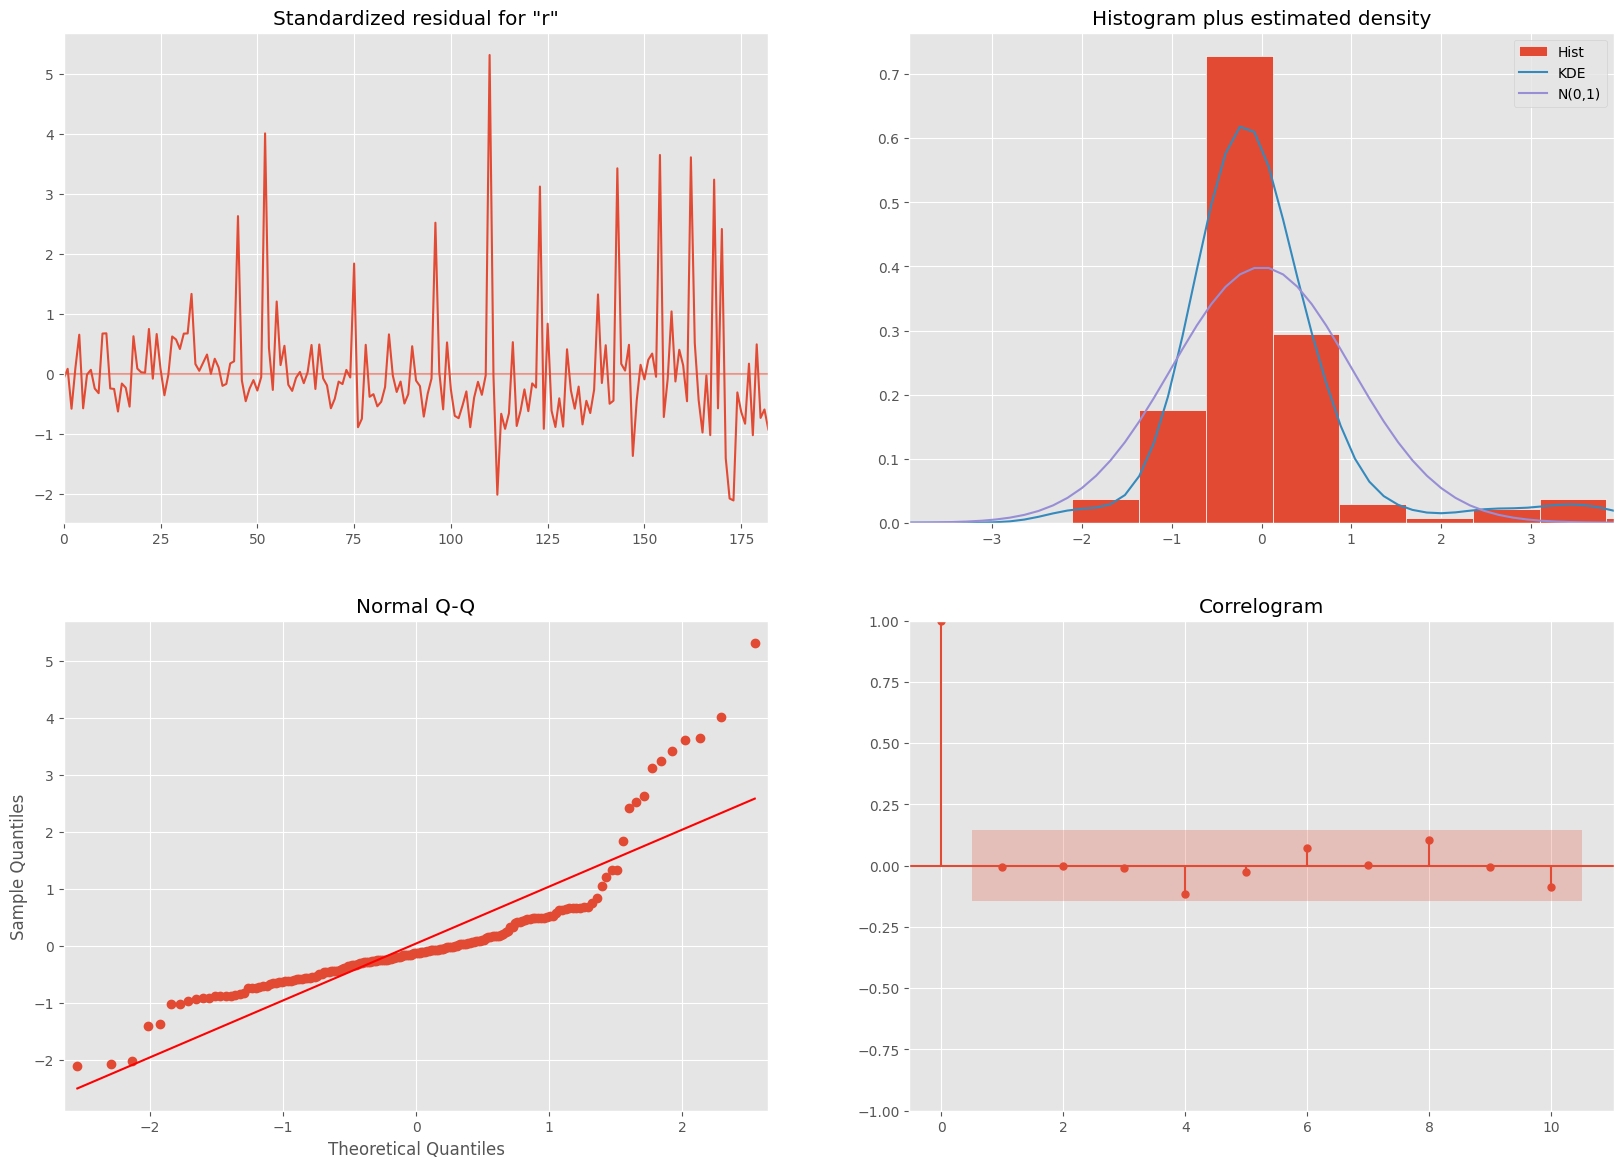

In [164]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In the plots above, we can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

## Results
Now let's create some predictions. We will use three methods:

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [165]:
pred0 = results.get_prediction(start='2022-10-21-00', dynamic=False)
pred0_ci = pred0.conf_int()


2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [166]:
pred1 = results.get_prediction(start='2022-10-21-00', dynamic=True)
pred1_ci = pred1.conf_int()


3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [167]:
pred2 = results.get_forecast(31)
pred2_ci = pred2.conf_int()
print(pred2_ci)

     lower rank  upper rank
235    2.900604    7.259852
236    2.436325    6.795582
237    2.307986    6.757797
238    3.024401    7.485233
239    2.119902    6.624792
240    2.285420    6.818859
241    2.154682    6.724058
242    2.136254    6.737795
243    2.507107    7.142093
244    2.850685    7.518155
245    1.981013    6.681075
246    3.038993    7.771272
247    2.405976    7.175661
248    2.323388    7.124880
249    2.136461    6.970570
250    2.475020    7.340889
251    2.000030    6.897744
252    2.149880    7.079031
253    2.231746    7.192292
254    2.624621    7.616333
255    2.379736    7.402433
256    2.361711    7.415198
257    2.134817    7.218910
258    2.519965    7.634481
259    2.567121    7.781131
260    2.450601    7.694430
261    2.228365    7.512373
262    3.136691    8.453546
263    2.136967    7.490120
264    2.278562    7.666458
265    2.077904    7.500964


Let's plot all this

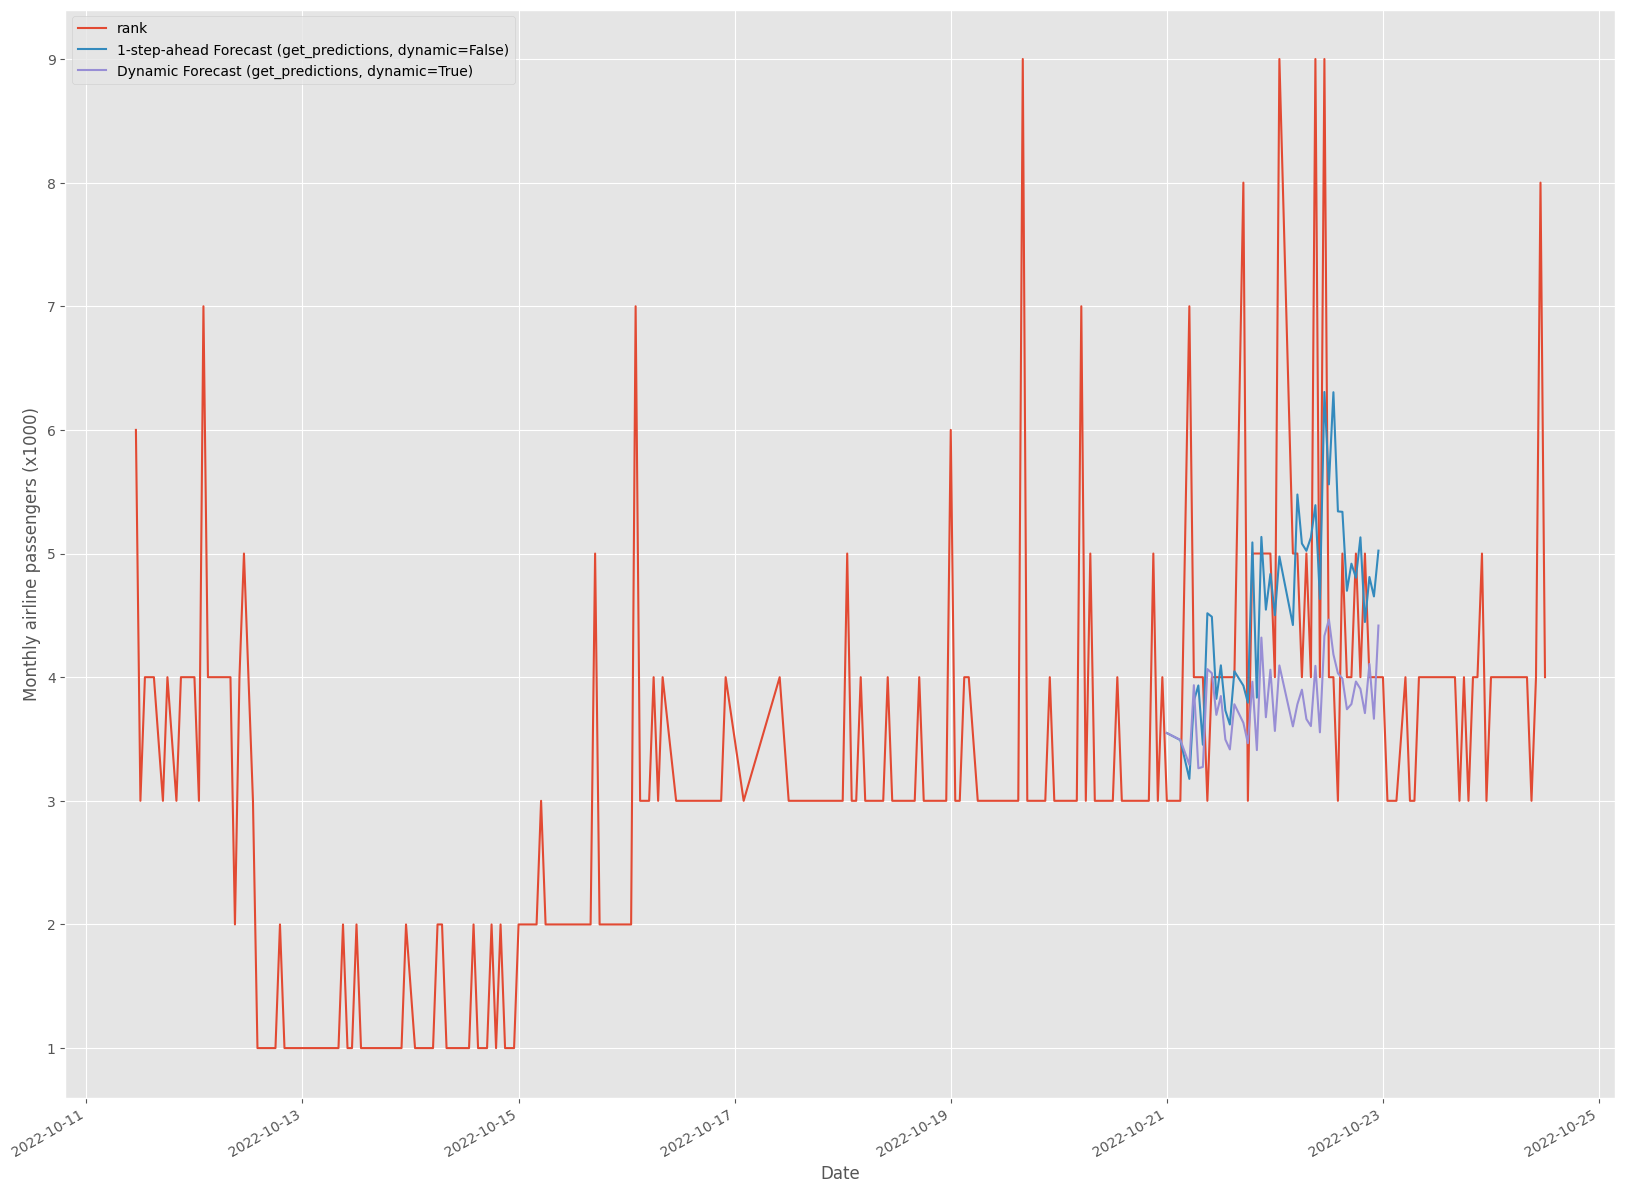

In [168]:
ax = data.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
# pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
# ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [169]:
prediction = pred2.predicted_mean.values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of product rank is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of product rank is 30.68%
